In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import LinearModel, LorentzianModel
from uncertainties import unumpy as up
from uncertainties import ufloat
from uncertainties import wrap
from pathlib import Path

In [2]:
def voigt1(x,s1,g1,o1,scale1):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)#+a*x**2+b
def voigt2(x,s1,s2,g1,g2,o1,o2,scale1,scale2):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)+scale2*scipy.special.voigt_profile(x-o2,s2,g2)#+a*x**2+b

In [3]:
def FWHM(s_p,g_p):
    s = ufloat(s_p.value,s_p.stderr)
    g = ufloat(g_p.value,g_p.stderr)
    fg=s*(8*up.log(2))**0.5
    fl=2*g
    return 0.5346*fl+((fg)**2+(0.2166*fl**2))**0.5

def uvoigt1(out_voigt):
    x_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x = ufloat(x_p.value,x_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    uv=wrap(voigt1)
    return uv(x,s1,g1,o1,scale1)

def uvoigt2(out_voigt):
    x1_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x2_p,s2_p,g2_p,o2_p,scale2_p=out_voigt.result.params['o2'],out_voigt.result.params['s2'],out_voigt.result.params['g2'],out_voigt.result.params['o2'],out_voigt.result.params['scale2']
    x1 = ufloat(x1_p.value,x1_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    x2 = ufloat(x2_p.value,x2_p.stderr)
    s2 = ufloat(s2_p.value,s2_p.stderr)
    g2 = ufloat(g2_p.value,g2_p.stderr)
    o2 = ufloat(o2_p.value,o2_p.stderr)
    scale2 = ufloat(scale2_p.value,scale2_p.stderr)


    uv=wrap(voigt2)

    p1 = uv(x1,s1,s2,g1,g2,o1,o2,scale1,scale2)
    p2 = uv(x2,s1,s2,g1,g2,o1,o2,scale1,scale2)
    return p1,p2

def uvoigt(out_voigt):
    try:
        return uvoigt2(out_voigt)
    except:
        return uvoigt1(out_voigt)

In [4]:
res = Path("results_1-4_ohne/voigt_fits_40_40_ohne.txt")
res.touch()
nf = open(res,"w")
nf.write("Peak\tAmplitude1\tAmplitude2\tmu1\tmu2\tsigma1\tsigma2\tgamma1\tgamma2\tFWHM1\tFWHM2\tHeight1\tHeight2\tredchi\n")

def bwrite(fr,fwhm1,height1):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.redchi)+"\n"
                )
        

def awrite(fr,fwhm1,height1,fwhm2,height2):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                str(fr.params['scale2'].value)+"\t"+str(fr.params['scale2'].stderr)+"\t"+                
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                str(fr.params['o2'].value)+"\t"+str(fr.params['o2'].stderr)+"\t"+                
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                str(fr.params['s2'].value)+"\t"+str(fr.params['s2'].stderr)+"\t"+                
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                str(fr.params['g2'].value)+"\t"+str(fr.params['g2'].stderr)+"\t"+                
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                str(fwhm2[0])+"\t"+str(fwhm2[1])+"\t"+                
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                str(height2[0])+"\t"+str(height2[1])+"\t"+                
                str(fr.redchi)+"\n"
                )
       

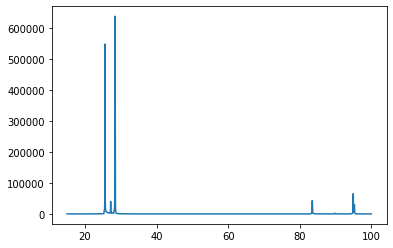

In [5]:
path =  'Data/Si_111_40_40_ohne_Fi.xy'
with open(path) as tf:
    data = np.loadtxt(tf,delimiter=" ").T

err = np.zeros(len(data[1]))
for i in range(len(err)):
    err[i] = (data[1,i])**0.5
data = np.vstack([data,err])
plt.plot(data[0],data[1])

In [6]:
#modell erstellen b1 = [25,26.2]->[1196,1339]  
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["o1"].set(value=25.5,min=25,max=26.2)
pars_voigt["scale1"].set(100)

#Fitten
out_voigt = model_voigt.fit(data[1,1196:1339],x=data[0,1196:1339],params=pars_voigt,weights=1/data[2,1196:1339],nan_policy='propagate')
b1f=out_voigt.fit_report()
b1p=np.array([np.arange(25,26.2,0.001),out_voigt.eval(x=np.arange(25,26.2,0.001))])


h1 = uvoigt(out_voigt).format(":.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)

In [7]:
#modell erstellen a1 = [28,29]->[1555,1675]    
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=28.4,min=28,max=29)
pars_voigt["o2"].set(value=28.5,min=28,max=29)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,1555:1675],x=data[0,1555:1675],params=pars_voigt,weights=1/data[2,1555:1675],nan_policy='propagate')
a1f=out_voigt.fit_report()
a1p=np.array([np.arange(28,29,0.001),out_voigt.eval(x=np.arange(28,29,0.001))])


h1 = uvoigt(out_voigt)[0].format(":.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)



In [8]:
#modell erstellen    b2 = [52.55,52.8]->[4493,4497]4493:4497
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0084,min=0,max=1)
pars_voigt["g1"].set(value=0.041,min=0,max=1)
pars_voigt["o1"].set(value=52.677,min=52.6,max=52.8)
pars_voigt["scale1"].set(20)

#Fitten
out_voigt = model_voigt.fit(data[1,4493:4523],x=data[0,4493:4523],weights=1/data[2,4493:4523],params=pars_voigt,nan_policy='propagate')
b2f=out_voigt.fit_report()
b2p=np.array([np.arange(52.55,52.8,0.001),out_voigt.eval(x=np.arange(52.55,52.8,0.001))])


h1 = uvoigt(out_voigt).format(":.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)

In [9]:
#modell erstellen a2 = [58.5,59.1]->[5205,5277]     
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.00147,min=0,max=1)
pars_voigt["o1"].set(value=58.8,min=58.7,max=58.85)
pars_voigt["o2"].set(value=58.98,min=58.9,max=59)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,5205:5277],x=data[0,5205:5277],params=pars_voigt,weights=1/data[2,5205:5277],nan_policy='propagate')
a2f=out_voigt.fit_report()
a2p=np.array([np.arange(58.5,59.1,0.001),out_voigt.eval(x=np.arange(58.5,59.1,0.001))])


h1 = uvoigt(out_voigt)[0].format(":.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)

In [10]:
#modell erstellen    b3 = [82.5,84.5]->[8077,8317]
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0084,min=0,max=1)
pars_voigt["g1"].set(value=0.041,min=0,max=1)
pars_voigt["o1"].set(value=83.5,min=82.5,max=84.5)
pars_voigt["scale1"].set(20)

#Fitten
out_voigt = model_voigt.fit(data[1,8077:8317],x=data[0,8077:8317],weights=1/data[2,8077:8317],params=pars_voigt,nan_policy='propagate')
b3f=out_voigt.fit_report()
b3p=np.array([np.arange(82.5,84.5,0.001),out_voigt.eval(x=np.arange(82.5,84.5,0.001))])


h1 = uvoigt(out_voigt).format(":.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":.5").split("+/-")

bwrite(out_voigt.result,fwhm1,h1)

In [11]:
#modell erstellen a3 = [94,96]->[9454,9693]       
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=94.8,min=94,max=96)
pars_voigt["o2"].set(value=95.25,min=94,max=96)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,9454:9693],x=data[0,9454:9693],params=pars_voigt,weights=1/data[2,9454:9693],nan_policy='propagate')
a3f=out_voigt.fit_report()
a3p=np.array([np.arange(94,96,0.001),out_voigt.eval(x=np.arange(94,96,0.001))])


h1 = uvoigt(out_voigt)[0].format(":.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)


nf.close()

(52.0, 60.0)

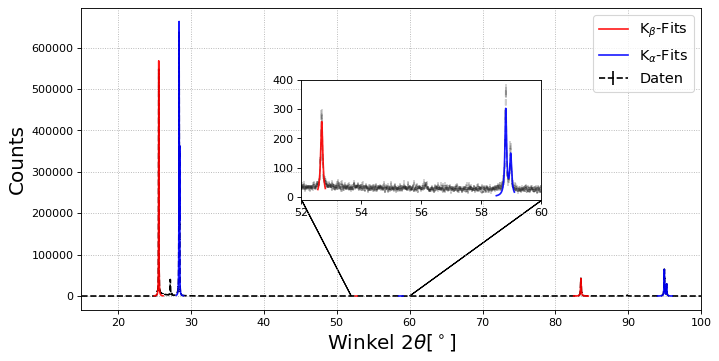

In [12]:
fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',label='Daten')
plt.plot(b1p[0],b1p[1],zorder=10,label='K'r'$_\beta$''-Fits',color='r',alpha=0.9)
plt.plot(a1p[0],a1p[1],zorder=10,label='K'r'$_\alpha$''-Fits',color='b',alpha=0.9)
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.plot(b3p[0],b3p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a3p[0],a3p[1],zorder=10,color='b',alpha=0.9)

plt.legend(fontsize=13)
plt.grid(axis='both',linestyle=':')
plt.xlim(15,100)
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.arrow(45.25,230000,6.75,-230000)
plt.arrow(78,230000,-18,-230000)


# this is an inset axes over the main axes
a = plt.axes([.4, .4, .3, .3])
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',alpha=0.2)
plt.ylim(-10,400)
plt.xlim(52,60)
#plt.savefig('plots_1-4_ohne/hauptplots/spek_40_40_ohne.pdf')

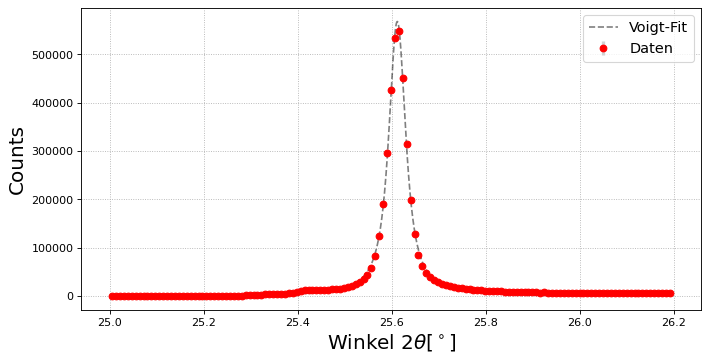

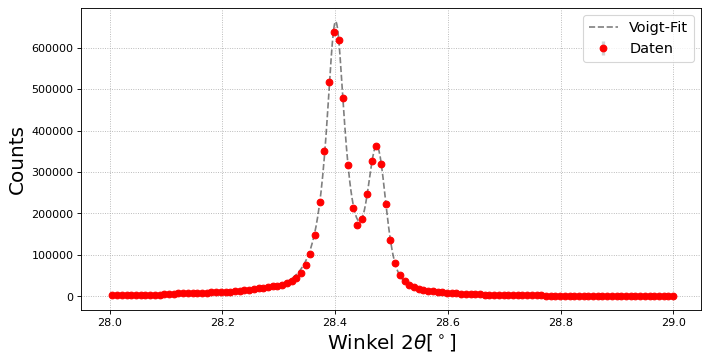

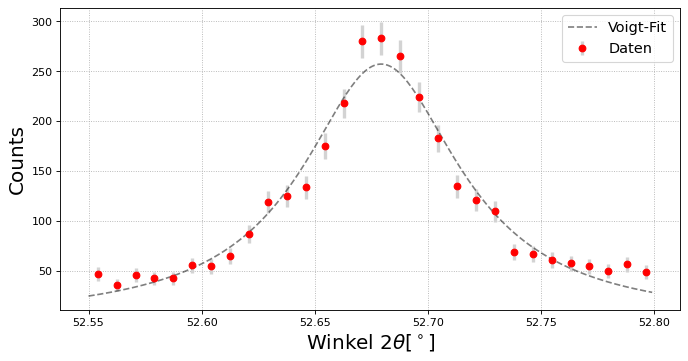

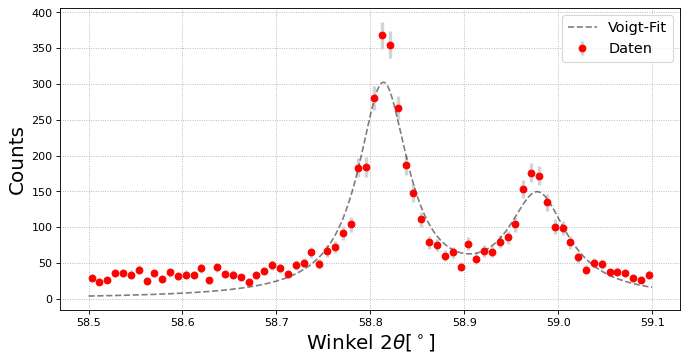

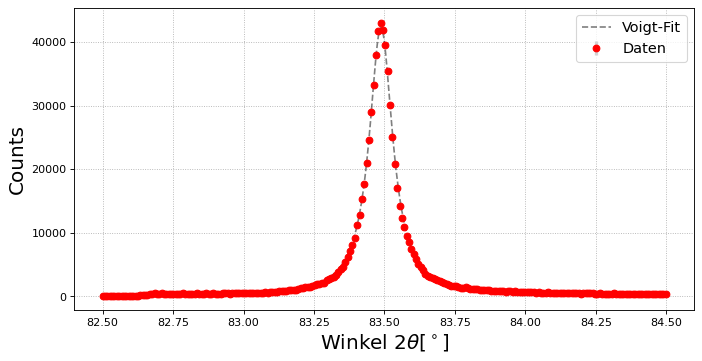

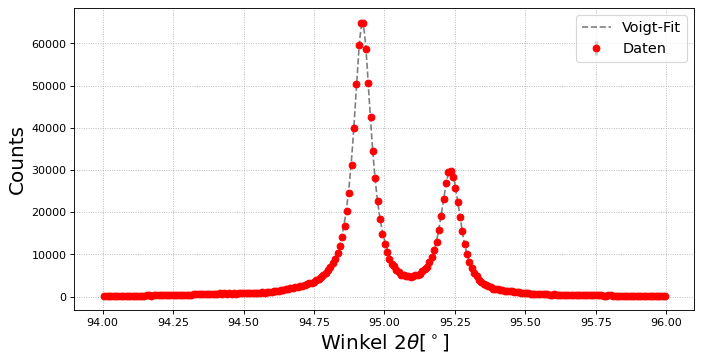

In [13]:
#plt.style.use('fivethirtyeight')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,1196:1339],data[1,1196:1339],yerr=data[2,1196:1339],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b1p[0],b1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fits_40_40_ohne/b1.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,1555:1675],data[1,1555:1675],yerr=data[2,1555:1675],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a1p[0],a1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fits_40_40_ohne/a1.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,4493:4523],data[1,4493:4523],yerr=data[2,4493:4523],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b2p[0],b2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fits_40_40_ohne/b2.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,5205:5277],data[1,5205:5277],yerr=data[2,5205:5277],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a2p[0],a2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fits_40_40_ohne/a2.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,8077:8317],data[1,8077:8317],yerr=data[2,8077:8317],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b3p[0],b3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fits_40_40_ohne/b3.pdf')


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,9454:9693],data[1,9454:9693],yerr=data[2,9454:9693],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a3p[0],a3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
#plt.savefig('plots_1-4_ohne/voigt_fits_40_40_ohne/a3.pdf')

In [14]:
print('b1#######################################')
print(b1f)
print('a1#######################################')
print(a1f)
print('b2#######################################')
print(b2f)
print('a2#######################################')
print(a2f)
print('b3#######################################')
print(b3f)
print('a3#######################################')
print(a3f)


b1#######################################
[[Model]]
    Model(voigt1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 143
    # variables        = 4
    chi-square         = 285178.410
    reduced chi-square = 2051.64324
    Akaike info crit   = 1094.51767
    Bayesian info crit = 1106.36904
[[Variables]]
    s1:      0.00651006 +/- 0.00221753 (34.06%) (init = 0.0137)
    g1:      0.01861728 +/- 9.2820e-04 (4.99%) (init = 0.0137)
    o1:      25.6121109 +/- 6.2236e-04 (0.00%) (init = 25.5)
    scale1:  36623.8734 +/- 801.191379 (2.19%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(s1, g1) = -0.744
a1#######################################
[[Model]]
    Model(voigt2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 120
    # variables        = 8
    chi-square         = 45125.4708
    reduced chi-square = 402.905990
    Akaike info crit   = 727.565